<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/pnx_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
# install required additional libraries
!pip install -U segmentation-models
!pip install -U albumentations
!pip install -U keras_lr_finder

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [117]:
# import libraries and functions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import glob, cv2, gzip, tqdm

# %tensorflow_version 2.x
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, concatenate, Lambda
from tensorflow.keras import Model, backend as K, callbacks as cb, optimizers

%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet

print('TensorFlow version is:', tf.__version__)

env: SM_FRAMEWORK=tf.keras
TensorFlow version is: 2.14.0


In [118]:
ls

class_distribution.png  Pneumothorax-Segmentation/  Untitled.ipynb
dataset/                pnx_model/
pics/                   pnx_segmentation.ipynb


In [119]:
# load the dataset
path = 'dataset/'
img_file = gzip.GzipFile(filename=path+'training_images.npy.gz', mode='r')
%time images = np.load(file=img_file)
msk_file = gzip.GzipFile(filename=path+'training_masks_resized.npy.gz', mode='r')
%time masks = np.load(file=msk_file)
metadata = pd.read_csv(filepath_or_buffer=path+'converted-train-rle.csv', index_col=None)
age = metadata.loc[:, 'PatientAge']
sex = metadata.loc[:, 'PatientSex']
view = metadata.loc[:, 'ImageView']

print('metadata columns:', metadata.columns)
print('shape of the dataset:', images.shape)
print('shape of the masks:', masks.shape)

CPU times: user 15.2 s, sys: 790 ms, total: 16 s
Wall time: 17.6 s
CPU times: user 6.99 s, sys: 427 ms, total: 7.42 s
Wall time: 7.52 s
metadata columns: Index(['ImageId', 'PatientId', 'PatientAge', 'PatientSex', 'ImageView'], dtype='object')
shape of the dataset: (10675, 512, 512)
shape of the masks: (10675, 512, 512)


In [120]:
# first, load the dataset
path = 'dataset'
training_path = path + '/dicom-images-train/*/*/*.dcm'
test_path = path + '/dicom-images-test/_/_/*.dcm'

%time X_train = glob.glob(pathname=training_path)
%time X_test = glob.glob(pathname=test_path)

metadata = pd.read_csv(filepath_or_buffer=path+'/train-rle.csv', index_col=None)
print('metadata header:', metadata.columns)

CPU times: user 280 ms, sys: 321 ms, total: 601 ms
Wall time: 13.5 s
CPU times: user 262 µs, sys: 0 ns, total: 262 µs
Wall time: 716 µs
metadata header: Index(['ImageId', ' EncodedPixels'], dtype='object')


In [121]:
# only keep images with pneumothorax (if needed)
images_with_pnx = list()
masks_with_pnx = list()
for image, mask in zip(images, masks):
    if np.max(mask) == 1:
        images_with_pnx.append(image)
        masks_with_pnx.append(mask)

images = np.array(images_with_pnx)
masks = np.array(masks_with_pnx)
del images_with_pnx, masks_with_pnx

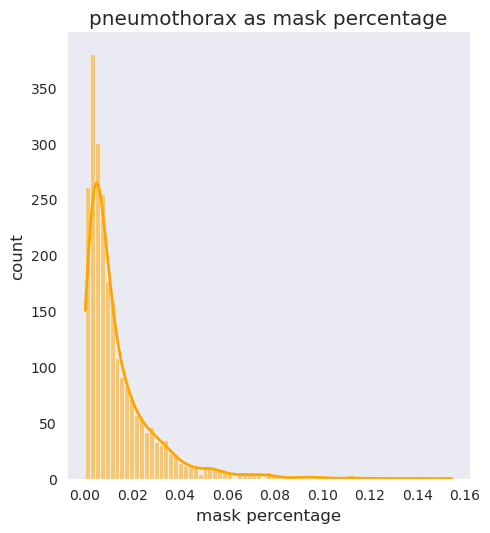

In [122]:
# plot pneumothorax as mask percentage for dataset masks
mask_percentages = list()
h, w = masks[0].shape[:2]
for mask in masks:
    if np.sum(mask) > 0:
        mask_percentages.append(np.sum(mask) / (h * w))

sbn.set_style('dark')
plot = sbn.displot(data=mask_percentages, color='orange', kde=True)
plot.set(xlabel='mask percentage', ylabel='count', title='pneumothorax as mask percentage')

In [123]:
# prep: second resize
images = np.array([cv2.resize(image, dsize=(256, 256)) for image in images]).astype('uint8')
masks = np.array([cv2.resize(mask, dsize=(256, 256)) for mask in masks]).astype('float64')
print('resized masks and images into 256*256 pixels!')

# prep: CLAHE
images = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in images])
print('applied CLAHE on images!')

# prep: dimension expansion
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)
print('expanded dimensions of images and masks!')

# prep: greyscale to RGB
images = np.array([np.concatenate((image, image, image), axis=-1) for image in images])
print('concatenated images to increase channels from 1 to 3!')

# prep: train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=10)
del images, masks
print('splitted into training/validation sets!')


print('training images/masks shape:', X_train.shape, y_train.shape)
print('validation images/masks shape:', X_val.shape, y_val.shape)
print('max val of images:', np.max(X_train), 'and max val of masks:', np.max(y_train))

resized masks and images into 256*256 pixels!
applied CLAHE on images!
expanded dimensions of images and masks!
concatenated images to increase channels from 1 to 3!
splitted into training/validation sets!
training images/masks shape: (2141, 256, 256, 3) (2141, 256, 256, 1)
validation images/masks shape: (238, 256, 256, 3) (238, 256, 256, 1)
max val of images: 255 and max val of masks: 1.0


In [124]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1, threshold=0.5):
    y_true_flt = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_flt = K.cast(K.greater(K.flatten(y_pred), threshold), 'float32')  # Replace pixels higher than a threshold with 1.0
    overlap = K.sum(y_true_flt * y_pred_flt)
    total_area = K.sum(y_true_flt) + K.sum(y_pred_flt)
    dsc = (2. * overlap + smooth) / (total_area + smooth)
    return dsc

def iou_coef(y_true, y_pred, smooth=1, threshold=0.5):
    y_true_flt = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_flt = K.cast(K.greater(K.flatten(y_pred), threshold), 'float32')  # Replace pixels higher than a threshold with 1.0
    intersection = K.sum(y_true_flt * y_pred_flt)
    union = K.sum(y_true_flt) + K.sum(y_pred_flt) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred, w_bce=1, w_dice=1, smoothen=False):
    bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.4 * smoothen)
    weighted_bce = w_bce * bce(y_true, y_pred)
    weighted_dice = w_dice * dice_loss(y_true, y_pred)
    return weighted_bce + weighted_dice

def bce_logdice_loss(y_true, y_pred, w_bce=1, w_logdice=1, smoothen=False):
    bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1 * smoothen)
    weighted_bce = w_bce * bce(y_true, y_pred)
    weighted_logdice = w_logdice * K.log(1.0 - dice_loss(y_true, y_pred))
    return weighted_bce - weighted_logdice


In [125]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32, augmentor=None, shuffle=True):
        'initialization'
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        self.indices = np.arange(len(x))
        self.counter = 0
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'updates indices after each epoch and resets counter'
        if self.shuffle == True:
            np.random.shuffle(self.indices)
        self.counter = 0
    
    def __len__(self):
        'denotes number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))-1
    
    def __getitem__(self, index=None):
        'generates one batch of data'
        # Generate indexes of the batch
        x_batch = list()
        y_batch = list()
        # select indexed samples from images and masks
        start = self.counter * self.batch_size
        for i in range(self.batch_size):
            x_batch.append(self.x[self.indices[start+i]])
            y_batch.append(self.y[self.indices[start+i]])
        self.counter += 1

        if self.augmentor is None:
            return np.array(x_batch), np.array(y_batch)
        else:
            x_aug, y_aug = list(), list()      
            for image, mask in zip(x_batch, y_batch):
                augmented = self.augmentor(image=image, mask=mask)
                x_aug.append(augmented['image'])
                y_aug.append(augmented['mask'])
            return np.array(x_aug), np.array(y_aug)

In [126]:
import cv2
import albumentations as alb
from albumentations import Compose, OneOf, ToFloat

cnt = cv2.BORDER_CONSTANT
transformer = Compose([alb.CoarseDropout(p=0.3), 
                       OneOf([alb.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3), alb.RandomGamma()], p=0.5),
                       OneOf([alb.GridDistortion(border_mode=cnt), alb.OpticalDistortion(border_mode=cnt),
                              alb.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, border_mode=cnt)], p=0.3),
                       alb.Rotate(limit=20, border_mode=cnt, p=0.7),
                       alb.ShiftScaleRotate(shift_limit=0, scale_limit=0.25, rotate_limit=0,
                                            border_mode=cnt, p=0.7),
                       ToFloat(max_value=1, p=1.0)])

val_transformer = Compose([ToFloat(max_value=1, p=1.0)])

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax')

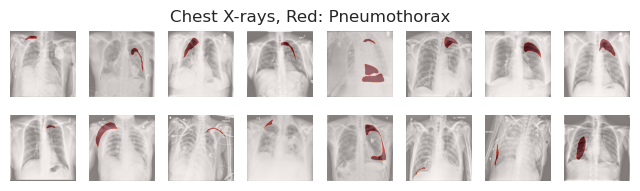

In [127]:
a = DataGenerator(x=X_train, y=y_train, batch_size=16)
images, masks = a.__getitem__()
max_images = 16
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, (im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax")

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax')

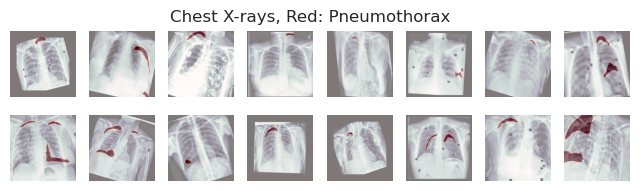

In [128]:
a = DataGenerator(x=X_train, y=y_train, batch_size=16, augmentor=transformer)
images, masks = a.__getitem__()
max_images = 16
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, (im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax")

In [161]:
# define stochastic weight averaging as a callback
class SWA(tf.keras.callbacks.Callback):
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)
        else:
            pass

    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')


# define learning rate scheduler function
def cosine_anneal_schedule(epoch, num_epochs, init_lr=0.001):
    cos_inner = np.pi * (epoch % num_epochs)
    cos_inner /= num_epochs
    cos_out = np.cos(cos_inner) + 1
    return float(init_lr / 2 * cos_out)

early_stopping = cb.EarlyStopping(monitor='val_dice_coef', patience=15, restore_best_weights=True)

reduce_lr_on_plateau = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=9, min_lr=1e-7)


# define callbacks
checkpoint = cb.ModelCheckpoint("pnx_model/eps={epoch:03d}_valDice={val_dice_coef:.4f}.hdf5", 
                                monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)
lr_scheduler = cb.LearningRateScheduler(cosine_anneal_schedule, verbose=1)
weight_averager = SWA(filepath='pnx_model/keras_swa.model', swa_epoch=27)

cb_list = [lr_scheduler, early_stopping, reduce_lr_on_plateau]

In [152]:
# # develop model architecture: U-Net with CheXNet backbone
# chexnet = 'models/chexnet_no_top.hdf5'
# model = Unet(backbone_name='resnet152', input_shape=(256, 256, 3),
#              encoder_weights='imagenet', encoder_freeze=False)
# model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef])
# model.summary()

In [157]:
ls

class_distribution.png  Pneumothorax-Segmentation/  Untitled.ipynb
dataset/                pnx_model/
pics/                   pnx_segmentation.ipynb


In [162]:
import tensorflow as tf
from segmentation_models import Unet
# from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# Define the input shape
input_shape = (256, 256, 3)  # Adjust the input shape as needed

# Load CheXNet backbone (pre-trained weights)
chexnet = 'Pneumpthorax-Segment/pnx_model/CheXNet_model.hdf5'

# Create a U-Net model with the ResNet34 backbone
backbone_name = 'resnet152'
# preprocess_input = get_preprocessing(backbone_name)
model = Unet(
    backbone_name=backbone_name,
    input_shape=input_shape,
    encoder_weights=None,  # Do not use pre-trained weights from the backbone
    encoder_freeze=True,   # Freeze the backbone layers
)

# Load CheXNet weights into the U-Net model (modify the layer names as needed)
chexnet_model = tf.keras.models.load_model('CheXNet_model.hdf5')
for layer in chexnet_model.layers:
    if layer.name.startswith('encoder_'):  # Modify this condition based on your layer names
        model.get_layer(layer.name).set_weights(layer.get_weights())

# Compile the model with appropriate loss and metrics
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_coef]  # You can add more metrics as needed
)

# Print the model summary
# model.summary()


In [135]:
# !python3 -m pip install tensorflow[and-cuda]
# # Verify the installation:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"


In [163]:
# train model using custom data generation and augmentor
training_gen = DataGenerator(x=X_train, y=y_train, batch_size=128, augmentor=transformer)
val_gen = DataGenerator(x=X_val, y=y_val, batch_size=128, augmentor=val_transformer)

training = model.fit(training_gen, epochs=150, verbose=1, validation_data=val_gen,
                     callbacks=cb_list)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/150
15/15 [==============================] - 64s 932ms/step - loss: 1.6680 - dice_coef: 0.0252 - iou_coef: 0.0128 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 5.566475780316438e-12.
Epoch 2/150
15/15 [==============================] - 17s 1s/step - loss: 1.4737 - dice_coef: 0.0217 - iou_coef: 0.0110 - lr: 5.5665e-12

Epoch 3: LearningRateScheduler setting learning rate to 0.0009998663497589543.
Epoch 3/150
15/15 [==============================] - 15s 957ms/step - loss: 1.3926 - dice_coef: 0.0171 - iou_coef: 0.0086 - lr: 9.9987e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0006532449553903917.
Epoch 4/150
15/15 [==============================] - 14s 870ms/step - loss: 1.2739 - dice_coef: 0.0030 - iou_coef: 0.0015 - lr: 6.5324e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0008220601635447102.
Epoch 5/150
15/15 [==============================] - 15s 998ms/step

KeyError: 'val_loss'

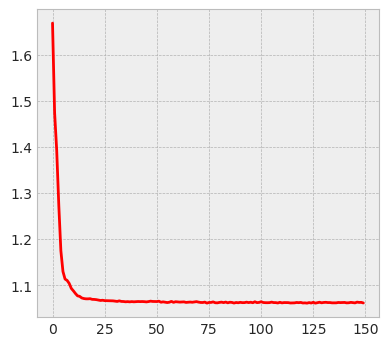

In [164]:
# plot learning curves: loss, dice score, iou score
fig = plt.figure(figsize=(15, 4))
plt.style.use('bmh')
plt.subplot(1, 3, 1)
plt.plot(training.history['loss'], color='r', label='training_loss')
# plt.plot(training.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(training.history['dice_coef'], color='r', label='training_dsc')
plt.plot(training.history['val_dice_coef'], color='g', label='validation_dsc')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(training.history['iou_coef'], color='r', label='training_iou')
plt.plot(training.history['val_iou_coef'], color='g', label='validation_iou')
plt.legend()
plt.show()
fig.savefig('pics/losses3.png', bbox_inches='tight')

In [ ]:
new_val_gen = DataGenerator(X_val, y_val, batch_size=1, augmentor=val_transformer, shuffle=False)

def predict_result(model, validation_generator): 
    preds_test1 = model.predict(validation_generator, verbose=1)
    return preds_test1

preds_valid = predict_result(model, new_val_gen)

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    # print(len(y_true_in))
    # print(len(y_pred_in))
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


## Scoring for last model
thresholds = np.linspace(0.2, 0.9, 31)
ious = np.array([iou_metric_batch(y_val[:-1], np.int32(preds_valid > threshold)) for threshold in thresholds])

In [ ]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
for _ in range(10):
    idx = np.random.randint(0, len(X_train))
    fig = plt.figure(num=3, figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.title('image/ idx=%d' % idx)
    plt.imshow(X=X_train[idx].squeeze(), cmap='bone')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('ground-truth')
    plt.imshow(X=y_train[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('prediction')
    pred = model.predict(np.expand_dims(X_train[idx], axis=0))
    plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
for i in range(10):
    idx = np.random.randint(0, len(X_val))
    fig = plt.figure(num=3, figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.title('image/ idx=%d' % idx)
    plt.imshow(X=X_val[idx].squeeze(), cmap='bone')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('ground-truth')
    plt.imshow(X=y_val[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('prediction')
    pred = model.predict(np.expand_dims(X_val[idx], axis=0))
    plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
    plt.axis('off')
    plt.show()